# Intro



In [1]:
Starter notebook for [Hotel-ID to Combat Human Trafficking 2022 - FGVC9](https://www.kaggle.com/competitions/hotel-id-to-combat-human-trafficking-2022-fgvc9) competition using model to generate embeddings as image representation and then searching for the most similar images. 

Inference notebook: [Hotel-ID starter - similarity- inference](https://www.kaggle.com/code/michaln/hotel-id-starter-similarity-inference)

## Embeddings
To compare images we can use model to generate embeddings as their representation and then calculate distance/similarity between images to search for the most similar one.

We can use pretrained model without the last classification layer and add two linear layers. Features from pretrianed CNN will be used as input for embedding layer and result of embedding layer will be used for classification layer. Model will then output embeddings and predicted class. We can use a class prediction to calculate loss and train the model further and embeddings to search for similar images. Embeddings should contain enough information to predict correct class so they should be good representations of the image. 

![Embedding model](https://github.com/michal-nahlik/kaggle-hotel-id-2022/raw/master/doc/img/embedding_model.png)

SyntaxError: invalid syntax (640416134.py, line 1)

In [ ]:
## Similarity
To find if images are similar we can calculate distance/similarity of their emebeddings using methods like [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) or [Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).

After training model we can get embeddings for all images with known class (hotel id) and calculate their similarity to the test image we want to classify. We can rank the train images based on their similarity to embeddings of the test image and find 5 train images from different hotels that are most similar.

## Data
This notebook uses preprocessed images that were resized and padded to 256x256 pixel.

Used dataset: [Hotel-ID 2022 train images 256x256](https://www.kaggle.com/datasets/michaln/hotelid-2022-train-images-256x256) created by [Hotel-ID - image preprocessing - 256x256](https://www.kaggle.com/code/michaln/hotel-id-image-preprocessing-256x256) notebook.

## Classification starter notebook
Previous starter notebook using simple classification:
- [Hotel-ID starter - classification - traning](https://www.kaggle.com/code/michaln/hotel-id-starter-classification-traning)
- [Hotel-ID starter - classification - inference](https://www.kaggle.com/code/michaln/hotel-id-starter-classification-inference)

This notebook has similar structure and is extension of it to show different approach.

# Imports

In [ ]:
!pip install huggingface_hub -U

In [ ]:
import huggingface_hub
print(huggingface_hub.__version__)

In [33]:
!pip uninstall safetensors -y
!pip install safetensors==0.3.0
import safetensors
print(safetensors.__version__)

Found existing installation: safetensors 0.3.0
Uninstalling safetensors-0.3.0:
  Successfully uninstalled safetensors-0.3.0
  Using cached safetensors-0.3.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
0.3.0


In [34]:
!pip uninstall transformers -y
!pip install transformers==4.29.2
import transformers
print(transformers.__version__)

Found existing installation: transformers 4.29.2
Uninstalling transformers-4.29.2:
  Successfully uninstalled transformers-4.29.2
  Using cached transformers-4.29.2-py3-none-any.whl (7.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.9.1 requires transformers<4.17,>=4.1, but you have transformers 4.29.2 which is incompatible.
4.29.2


In [35]:
#!pip install torch==2.0.1+cu117 torchvision==0.15.2+cu117 -f https://download.pytorch.org/whl/torch_stable.html
#transformers==4.29.2 and safetensors==0.3.0
!nvidia-smi


Mon Feb 17 21:47:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             27W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [36]:
import torch
print("Pytorch version：")
print(torch.__version__)
print("CUDA Version: ")
print(torch.version.cuda)
print("cuDNN version is :")
print(torch.backends.cudnn.version())

Pytorch version：
1.9.1
CUDA Version: 
11.0
cuDNN version is :
8005


In [37]:
!pip install timm

In [38]:
import numpy as np
import pandas as pd
import random
import os

In [39]:
from PIL import Image as pil_image
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [40]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import timm

from sklearn.metrics.pairwise import cosine_similarity

# Global

In [41]:
IMG_SIZE = 256
SEED = 42
N_MATCHES = 5

PROJECT_FOLDER = "../input/hotel-id-to-combat-human-trafficking-2022-fgvc9/"
DATA_FOLDER = "../input/hotelid-2022-train-images-256x256/"
IMAGE_FOLDER = DATA_FOLDER + "images/"
OUTPUT_FOLDER = ""

train_df = pd.read_csv(os.path.join(DATA_FOLDER, 'train.csv'))

In [42]:
print(os.listdir(PROJECT_FOLDER))
print(os.listdir(DATA_FOLDER))

['sample_submission.csv', 'train_images', 'train_masks', 'test_images']
['images', 'train.csv']


In [43]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Dataset and transformations

Coarse dropout with fill_value=(255,0,0) (full red channel) is used to simulate the occlussions like the one in test dataset. 
```python
A.CoarseDropout(p=1., max_holes=1, 
                min_height=IMG_SIZE//4, max_height=IMG_SIZE//2,
                min_width=IMG_SIZE//4,  max_width=IMG_SIZE//2, 
                fill_value=(255,0,0))
```

In [44]:
import albumentations as A
import albumentations.pytorch as APT
import cv2 

# used for training dataset - augmentations and occlusions
train_transform = A.Compose([
    #A.RandomCrop(width=256, height=256),
    #A.HorizontalFlip(p=0.75),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5, shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, interpolation=cv2.INTER_NEAREST, border_mode=cv2.BORDER_CONSTANT),
    A.OpticalDistortion(p=0.25, distort_limit=0.05, shift_limit=0.01),
    A.Perspective(p=0.25, scale=(0.05, 0.1)),
    A.ColorJitter(p=0.75, brightness=0.25, contrast=0.25, saturation=0.15, hue=0.065),
    A.CoarseDropout(p=0.5, min_holes=1, max_holes=5, 
                    min_height=IMG_SIZE//16, max_height=IMG_SIZE//8,
                    min_width=IMG_SIZE//16,  max_width=IMG_SIZE//8), # normal coarse dropout
    
    A.CoarseDropout(p=0.75, max_holes=1, 
                    min_height=IMG_SIZE//4, max_height=IMG_SIZE//2,
                    min_width=IMG_SIZE//4,  max_width=IMG_SIZE//2, 
                    fill_value=(255,0,0)),# simulating occlusions in test data
    #A.RandomBrightnessContrast(p=0.75),
    A.ToFloat(),
    APT.transforms.ToTensorV2(),
])

# used for validation dataset - only occlusions
val_transform = A.Compose([
    A.CoarseDropout(p=0.75, max_holes=1, 
                    min_height=IMG_SIZE//4, max_height=IMG_SIZE//2,
                    min_width=IMG_SIZE//4,  max_width=IMG_SIZE//2, 
                    fill_value=(255,0,0)),# simulating occlusions
    A.ToFloat(),
    APT.transforms.ToTensorV2(),
])

# no augmentations
base_transform = A.Compose([
    A.ToFloat(),
    APT.transforms.ToTensorV2(),
])

In [45]:
class HotelTrainDataset:
    def __init__(self, data, transform=None, data_path="train_images/"):
        self.data = data
        self.data_path = data_path
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        record = self.data.iloc[idx]
        image_path = self.data_path + record["image_id"]
        image = np.array(pil_image.open(image_path)).astype(np.uint8)

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"]
        
        return {
            "image" : image,
            "target" : record['hotel_id_code'],
        }

# Model
Model uses pretrained CNN without classification layer. Features from CNN are used as input for embedding layer (linear) and embeddings are used for final classification. Model can output both embeddings and class prediction or just embeddings.

Input image -> [CNN] -> features -> [Embedding layer] -> embeddings -> [Classification layer] -> class prediction

class EmbeddingModel(nn.Module):
    def __init__(self, n_classes=100, embedding_size=64, backbone_name="resnet34"):
        super(EmbeddingModel, self).__init__()
        
        self.backbone = timm.create_model(backbone_name, num_classes=n_classes, pretrained=True)
        in_features = self.backbone.get_classifier().in_features
        
        self.backbone.classifier = nn.Identity()
        self.embedding = nn.Linear(in_features, embedding_size)
        self.classifier = nn.Linear(embedding_size, n_classes)

    def embed_and_classify(self, x):
        x = self.forward(x)
        return x, self.classifier(x)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.embedding(x)
        return x

# Model helper functions

In [47]:
# method to iterate loader and generate embeddings of images
# returns embeddings and image class
def generate_embeddings(loader, model, bar_desc="Generating embeds"):
    targets_all = []
    outputs_all = []
    
    model.eval()
    with torch.no_grad():
        t = tqdm(loader, desc=bar_desc)
        for i, sample in enumerate(t):
            input = sample['image'].to(args.device)
            target = sample['target'].to(args.device)
            output = model(input)
            
            targets_all.extend(target.cpu().numpy())
            outputs_all.extend(output.detach().cpu().numpy())

    targets_all = np.array(targets_all).astype(np.float32)
    outputs_all = np.array(outputs_all).astype(np.float32)
            
    return outputs_all, targets_all

In [48]:
def save_checkpoint(model, scheduler, optimizer, epoch, name, loss=None, score=None):
    checkpoint = {"epoch": epoch,
                  "model": model.state_dict(),
                  "scheduler": scheduler.state_dict(),
                  "optimizer": optimizer.state_dict(),
                  "loss": loss,
                  "score": score,
                  }

    torch.save(checkpoint, f"{OUTPUT_FOLDER}checkpoint-{name}.pt")


def load_checkpoint(model, scheduler, optimizer, name):
    checkpoint = torch.load(f"{OUTPUT_FOLDER}checkpoint-{name}.pt")

    model.load_state_dict(checkpoint["model"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    return model, scheduler, optimizer, checkpoint["epoch"]

# Train and validation functions

In [49]:
def train_epoch(args, model, loader, criterion, optimizer, scheduler, epoch):
    losses = []
    targets_all = []
    outputs_all = []
    
    model.train()
    t = tqdm(loader)
    
    for i, sample in enumerate(t):
        optimizer.zero_grad()
        
        images = sample['image'].to(args.device)
        targets = sample['target'].to(args.device)
        
        _, outputs = model.embed_and_classify(images)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
                
        losses.append(loss.item())
        targets_all.extend(targets.cpu().numpy())
        outputs_all.extend(torch.sigmoid(outputs).detach().cpu().numpy())

        score = np.mean(targets_all == np.argmax(outputs_all, axis=1))
        desc = f"Training epoch {epoch}/{args.epochs} - loss:{loss:0.4f}, accuracy: {score:0.4f}"
        t.set_description(desc)
        
    return np.mean(losses), score

In [50]:
def test_classification(loader, model):
    targets_all = []
    outputs_all = []
    
    model.eval()
    t = tqdm(loader, desc="Classification")
    
    for i, sample in enumerate(t):
        images = sample['image'].to(args.device)
        targets = sample['target'].to(args.device)
        
        _, outputs = model.embed_and_classify(images)
        
        targets_all.extend(targets.cpu().numpy())
        outputs_all.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        
    
    # repeat targets to N_MATCHES for easy calculation of MAP@5
    y = np.repeat([targets_all], repeats=N_MATCHES, axis=0).T
    # sort predictions and get top 5
    preds = np.argsort(-np.array(outputs_all), axis=1)[:, :N_MATCHES]
    # check if any of top 5 predictions are correct and calculate mean accuracy
    acc_top_5 = (preds == y).any(axis=1).mean()
    # calculate prediction accuracy
    acc_top_1 = np.mean(targets_all == np.argmax(outputs_all, axis=1))

    print(f"Classification accuracy: {acc_top_1:0.4f}, MAP@5: {acc_top_5:0.4f}")

In [51]:
# find 5 most similar images from different hotels and return their hotel_id_code
def find_matches(query, base_embeds, base_targets, k=N_MATCHES):
    distance_df = pd.DataFrame(index=np.arange(len(base_targets)), data={"hotel_id_code": base_targets})
    # calculate cosine distance of query embeds to all base embeds
    distance_df["distance"] = cosine_similarity([query], base_embeds)[0]
    # sort by distance and hotel_id
    distance_df = distance_df.sort_values(by=["distance", "hotel_id_code"], ascending=False).reset_index(drop=True)
    # return first 5 different hotel_id_codes
    return distance_df["hotel_id_code"].unique()[:N_MATCHES]
    

def test_similarity(args, base_loader, test_loader, model):
    base_embeds, base_targets = generate_embeddings(base_loader, model, "Generate base embeddings")
    test_embeds, test_targets = generate_embeddings(test_loader, model, "Generate test embeddings")
    
    preds = []
    for query_embeds in tqdm(test_embeds, desc="Similarity - match finding"):
        tmp = find_matches(query_embeds, base_embeds, base_targets)
        preds.extend([tmp])
        
    preds = np.array(preds)
    test_targets_N = np.repeat([test_targets], repeats=N_MATCHES, axis=0).T
    # check if any of top 5 predictions are correct and calculate mean accuracy
    acc_top_5 = (preds == test_targets_N).any(axis=1).mean()
    # calculate prediction accuracy
    acc_top_1 = np.mean(test_targets == preds[:, 0])
    print(f"Similarity accuracy: {acc_top_1:0.4f}, MAP@5: {acc_top_5:0.4f}")

# Prepare data

In [52]:
data_df = pd.read_csv(DATA_FOLDER + "train.csv")
# encode hotel ids
data_df["hotel_id_code"] = data_df["hotel_id"].astype('category').cat.codes.values.astype(np.int64)

In [53]:
# save hotel_id encoding for later decoding
hotel_id_code_df = data_df.drop(columns=["image_id"]).drop_duplicates().reset_index(drop=True)
hotel_id_code_df.to_csv(OUTPUT_FOLDER + 'hotel_id_code_mapping.csv', index=False)
# hotel_id_code_map = hotel_id_code_df.set_index('hotel_id_code').to_dict()["hotel_id"]

## Rescaling / rebalancing data

In [54]:
def rescale(counts_dict):
    max_size = max(counts_dict.values())
    
    new_counts = {k: rescale_fun(c, max_size) for k, c in counts_dict.items()}
    return new_counts

def rescale_fun(size, m):
    UPPER = m//4.500 #1.393
    LOWER = 8
    SCALING = (UPPER - min(UPPER, size))/UPPER
    SCALING = SCALING if SCALING else 1
    return int(min(UPPER, size * LOWER * SCALING))  # Do something curvy

counts = data_df['hotel_id'].value_counts().sort_values(ascending=False)
counts_dict = {  id_: count for id_, count in counts.iteritems()}
rescaling = rescale(counts_dict)
new_mapping = []
for index, row in data_df.iterrows():
    id_ = row['hotel_id']
    path = row['image_id']
    new_mapping.extend([[path, id_]]*(rescaling[id_]//counts_dict[id_]))
rebalanced_df = pd.DataFrame(new_mapping, columns=["image_id", "hotel_id"])
rebalanced_df.to_csv(OUTPUT_FOLDER+"train_balanced.csv")

# save hotel_id encoding for later decoding
rebalanced_df["hotel_id_code"] = rebalanced_df["hotel_id"].astype('category').cat.codes.values.astype(np.int64)
hotel_id_code_df = rebalanced_df.drop(columns=["image_id"]).drop_duplicates().reset_index(drop=True)
hotel_id_code_df.to_csv(OUTPUT_FOLDER +  'hotel_id_code_mapping.csv', index=False)

data_df = rebalanced_df

# Quick look at rebalanced data

We can see that most hotels have less than 20 images while there are few with over hundreds and one with over 1000. In case of classification weights or sampling might be useful to handle the imbalance. There is also 11 hotels with only 1 image so we should think about how to deal with them.

## Image count per hotel

In [55]:
group_df = data_df.groupby(["hotel_id"]).size().to_frame("image_count").sort_values("image_count")[::-1].reset_index()

# top and low
low_df = group_df.iloc[-50:]
top_df = group_df.iloc[:50]

fig = make_subplots(rows=2, cols=2, 
                    specs=[[{"colspan": 2}, None], [{}, {}]],
                    horizontal_spacing=0.02, vertical_spacing=0.2, 
                    shared_yaxes=False,
                    subplot_titles=("", "Top 50", "Bottom 50"))


fig.add_trace(go.Scatter(x=group_df["hotel_id"], y=group_df["image_count"], showlegend = False), 1, 1)
fig.add_trace(go.Bar(x=top_df["hotel_id"], y=top_df["image_count"], showlegend = False), 2, 1)
fig.add_trace(go.Bar(x=low_df["hotel_id"], y=low_df["image_count"], showlegend = False), 2, 2)

fig.update_yaxes(title_text="Image count", row=1, col=1)
fig.update_yaxes(title_text="Image count", row=2, col=1)
fig.update_xaxes(type="category", visible=False, row=1, col=1)
fig.update_xaxes(title_text="Hotel ID", type="category", row=2, col=1)
fig.update_xaxes(title_text="Hotel ID", type="category", row=2, col=2)

fig.update_layout(title="Image count per hotel", height=550)
fig.show()

In [56]:
fig = px.histogram(group_df, x="image_count", nbins=100, marginal="box", height=350)
fig.update_layout(title="Distribution of image count per hotel")
fig.update_traces(hovertemplate="Image count: %{x} <br>Hotel count: %{y}")
fig.show()

## Example of images

In [57]:
def show_images(ds, title_text, n_images=5):
    fig, ax = plt.subplots(1,5, figsize=(22,8))
    
    ax[0].set_ylabel(title_text)
    
    for i in range(5):
        d = ds.__getitem__(i)
        ax[i].imshow(d["image"].T)

### Train images without and with augmentations

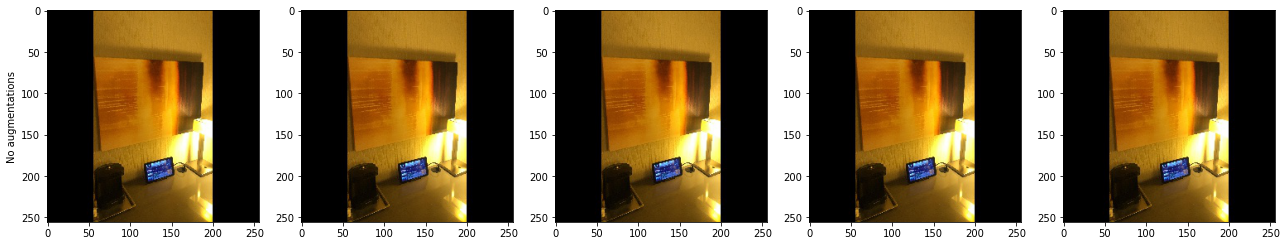

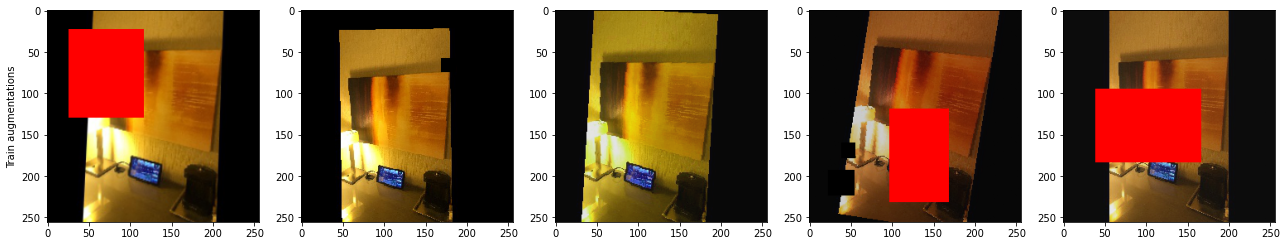

In [58]:
train_dataset = HotelTrainDataset(data_df, base_transform, data_path=IMAGE_FOLDER)
show_images(train_dataset, 'No augmentations')

train_dataset = HotelTrainDataset(data_df, train_transform, data_path=IMAGE_FOLDER)
show_images(train_dataset, 'Train augmentations')

### Test image example with occlusion

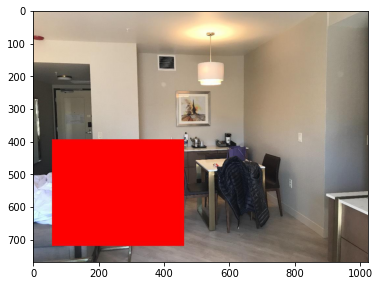

In [59]:
test_image = np.array(pil_image.open('../input/hotel-id-to-combat-human-trafficking-2022-fgvc9/test_images/abc.jpg')).astype(np.uint8)
plt.figure(figsize=(6,6))
plt.imshow(test_image)

# Train and evaluate

In [60]:
def train_and_validate(args, data_df):
    model_name = f"embedding-model-{args.backbone_name}-{IMG_SIZE}x{IMG_SIZE}"
    print(model_name)

    seed_everything(seed=SEED)

    # split data into train and validation set
    hotel_image_count = data_df.groupby("hotel_id")["image_id"].count()
    # hotels that have more images than samples for validation
    valid_hotels = hotel_image_count[hotel_image_count > args.val_samples]
    # data that can be split into train and val set
    valid_data = data_df[data_df["hotel_id"].isin(valid_hotels.index)]
    # if hotel had less than required val_samples it will be only in the train set
    valid_df = valid_data.groupby("hotel_id").sample(args.val_samples, random_state=SEED)
    train_df = data_df[~data_df["image_id"].isin(valid_df["image_id"])]
    

    train_dataset = HotelTrainDataset(train_df, train_transform, data_path=IMAGE_FOLDER)
    train_loader  = DataLoader(train_dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=True, drop_last=True)
    valid_dataset = HotelTrainDataset(valid_df, val_transform, data_path=IMAGE_FOLDER)
    valid_loader  = DataLoader(valid_dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=False)
    # base dataset for image similarity search
    base_dataset  = HotelTrainDataset(train_df, base_transform, data_path=IMAGE_FOLDER)
    base_loader   = DataLoader(base_dataset, num_workers=args.num_workers, batch_size=args.batch_size*4, shuffle=False)

    model = EmbeddingModel(args.n_classes, args.embedding_size ,args.backbone_name)
    model = model.to(args.device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
                    optimizer,
                    max_lr=args.lr,
                    epochs=args.epochs,
                    steps_per_epoch=len(train_loader),
                    div_factor=10,
                    final_div_factor=1,
                    pct_start=0.1,
                    anneal_strategy="cos",
                )
    
    start_epoch = 1
    
    for epoch in range(start_epoch, args.epochs+1):
        train_loss, train_score = train_epoch(args, model, train_loader, criterion, optimizer, scheduler, epoch)
        save_checkpoint(model, scheduler, optimizer, epoch, model_name, train_loss, train_score)
        test_classification(valid_loader, model)

    test_similarity(args, base_loader, valid_loader, model)
    
    # generate embeddings for all train images and save them for inference
    base_dataset   = HotelTrainDataset(data_df, base_transform, data_path=IMAGE_FOLDER)
    base_loader    = DataLoader(base_dataset, num_workers=args.num_workers, batch_size=args.batch_size*4, shuffle=False)
    base_embeds, _ = generate_embeddings(base_loader, model, "Generate embeddings for all images")
    data_df["embeddings"] = list(base_embeds)
    data_df.to_pickle(f"{OUTPUT_FOLDER}{model_name}_image-embeddings.pkl")

## Efficientnet-b0 training

In [61]:
%%time 

class args:
    epochs = 5
    lr = 1e-3
    batch_size = 64
    num_workers = 2
    val_samples = 1
    embedding_size = 512
    backbone_name = "resnet34"
    n_classes = data_df["hotel_id_code"].nunique()
    device = ('cuda' if torch.cuda.is_available() else 'cpu')

train_and_validate(args, data_df)

embedding-model-resnet34-256x256


AttributeError: module 'torch' has no attribute 'frombuffer'